In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.transforms.functional import to_pil_image, to_tensor

from catsndogs.training import cats, dogs, folder

# Data

The size of 'dog' is: torch.Size([3, 128, 128])


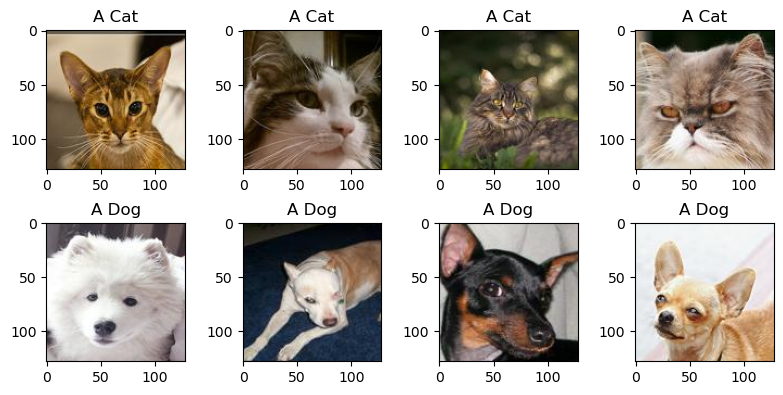

In [2]:
image_name = np.random.choice(dogs)
dog = to_tensor(Image.open(image_name))
print("The size of 'dog' is:", dog.size())

f, axs = plt.subplots(2, 4, figsize = (8, 4))
for i in range(4):
    img = np.random.choice(cats)
    ax = axs[0, i]
    ax.set_title("A Cat")
    ax.imshow(Image.open(img))
for i in range(4):
    img = np.random.choice(dogs)
    ax = axs[1, i]
    ax.set_title("A Dog")
    ax.imshow(Image.open(img))
plt.tight_layout()

In [3]:
# CUDA is available.
cuda = torch.device("cuda")
cpu = torch.device("cpu")
print(torch.cpu.is_available())
print(torch.cuda.is_available())

True
True


The type of image is: <class 'PIL.Image.Image'>
The label is: 0


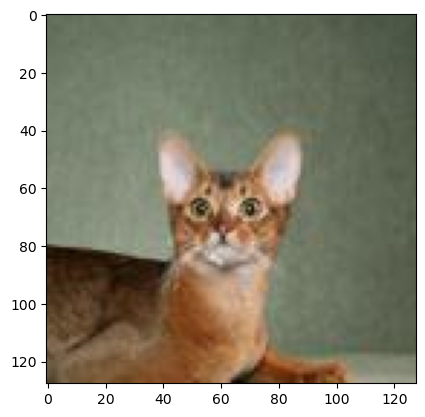

In [4]:
images = ImageFolder(folder)
image, label = images[0]
plt.imshow(image)
print("The type of image is:", type(image))
print("The label is:", label)

In [5]:
transform = Compose([ToTensor(),
                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
images = ImageFolder(folder, transform=transform)

n_train = int(0.9 * len(images))
n_val = len(images) - n_train
training_data_catsndogs, validation_data_catsndogs = torch.utils.data.random_split(images, (n_train, n_val))

# Fully Connected Neural Network or MLP Model

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, input_features, width):
        super().__init__()
        self.input_features = input_features
        self.fc_1 = nn.Linear(input_features, width)
        self.fc_2 = nn.Linear(width, width)
        self.fc_3 = nn.Linear(width, width)
        self.fc_4 = nn.Linear(width, 1)

    def forward(self, x):
        x = x.flatten(1, -1)
        x = self.fc_1(x)
        x = torch.relu(x)
        x = self.fc_2(x)
        x = torch.relu(x)
        x = self.fc_3(x)
        x = torch.relu(x)
        x = self.fc_4(x)
        return x

def train_epoch(training_loader, validation_loader, model, loss, optimizer, device):
    model.train()
    model.to(device)
    training_loss = 0.0
    n = len(training_loader)

    for i, (x, y) in enumerate(training_loader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        y = y.view_as(y_pred).float()
        l = loss(y_pred, y) 
        l.backward()
        optimizer.step()
        training_loss += l.item()
        print("Batch ({} / {}): Loss {:.2f}".format(i, n, l.item()), end="\r")

    training_loss /= n
    model.eval()
    validation_loss = 0.0
    n = len(validation_loader)

    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        l = loss(y_pred, y.view(-1, 1).float())
        validation_loss += l.item()
    validation_loss /= n
    model.to(torch.device("cpu"))
    return (training_loss, validation_loss)

class GradientDescent():
    def __init__(self, parameters, learning_rate):
        self.parameters = list(parameters)
        self.learning_rate = learning_rate

    def zero_grad(self):
        for p in self.parameters:
            if not p.grad is None:
                p.grad.zero_()

    def step(self):
        for p in self.parameters:
            p.data.add_(p.grad, alpha=-self.learning_rate)

Epoch 1/20, Training Loss: 0.652181025729122, Validation Loss: 0.6300401568412781
Epoch 2/20, Training Loss: 0.6173702464046249, Validation Loss: 0.6193290770053863
Epoch 3/20, Training Loss: 0.5883952009390636, Validation Loss: 0.6047613233327865
Epoch 4/20, Training Loss: 0.5548962063818093, Validation Loss: 0.5645064234733581
Epoch 5/20, Training Loss: 0.5232144138181066, Validation Loss: 0.5188534289598465
Epoch 6/20, Training Loss: 0.4915280119482293, Validation Loss: 0.5331847459077835
Epoch 7/20, Training Loss: 0.46214961036142094, Validation Loss: 0.5100726068019867
Epoch 8/20, Training Loss: 0.4305512811764177, Validation Loss: 0.5164627432823181
Epoch 9/20, Training Loss: 0.39123830683978206, Validation Loss: 0.5330877155065536
Epoch 10/20, Training Loss: 0.36367348177605363, Validation Loss: 0.5015749409794807
Epoch 11/20, Training Loss: 0.29149586608610956, Validation Loss: 0.5392032116651535
Epoch 12/20, Training Loss: 0.27782119236078606, Validation Loss: 0.53209002017974

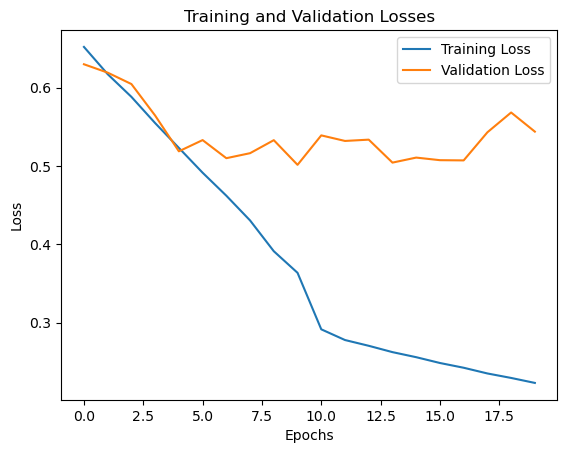

In [7]:
# Train network
training_loader_catsndogs = DataLoader(training_data_catsndogs, batch_size=32, shuffle=True)
validation_loader_catsndogs = DataLoader(validation_data_catsndogs, batch_size=32, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()

if torch.cuda.is_available():device = torch.device('cuda') # Default CUDA device
else: device = torch.device('cpu')
    
fc_model = FullyConnected(input_features=128*128*3, width=256)
optimizer = GradientDescent(fc_model.parameters(), learning_rate=0.01)
def update_learning_rate(optimizer, new_lr): optimizer.learning_rate = new_lr  # update learning rate in optimizer
epochs = 20
training_losses = []
validation_losses = []

for epoch in range(epochs):
    if epoch == 10:      # If epoch is 10, reduce learning rate
        update_learning_rate(optimizer, new_lr=0.001)

    train_loss, val_loss = train_epoch(training_loader_catsndogs, validation_loader_catsndogs, fc_model, loss, optimizer, device)
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

AUC: -0.7045113755388912


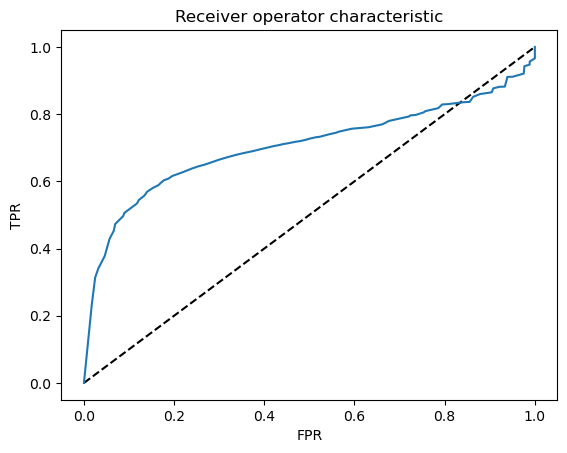

In [8]:
def receiver_operating_characteristic(model, validation_loader, ps):
    model.eval()
    device = next(model.parameters()).device
    y_true = []
    y_scores = []

    with torch.no_grad():  # No need to compute gradients
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs))
            y_scores.extend(outputs.view(-1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    fpr = []
    tpr = []
    for p in ps:
        y_pred = (np.array(y_scores) > p).astype(int)
        y_true = np.array(y_true)
        #print('ypre:',y_pred)
        TP = np.sum(y_pred *y_true)
        FP = np.sum(y_pred *(1-y_true))
        FN = np.sum((1-y_pred) *(1-y_true))
        TN = np.sum((1-y_pred) *y_true)

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        fpr.append(FPR)
        tpr.append(TPR)
    return np.array(fpr), np.array(tpr)

def plot_ROC(fpr,tpr):
    x = np.linspace(0, 1, 101)
    f, ax = plt.subplots(1, 1)
    ax.plot(x, x, c="k", ls="--")
    ax.plot(fpr, tpr)
    ax.set_ylabel("TPR")
    ax.set_xlabel("FPR")
    ax.set_title("Receiver operator characteristic")

def auc_roc(fpr, tpr):
    area = 0
    for i in range(1, len(fpr)):
        h = (tpr[i] + tpr[i-1]) / 2  # Average height- trapezoid
        w = fpr[i] - fpr[i-1]        # Width- trapezoid
        area += w * h  
    return area

fpr, tpr = receiver_operating_characteristic(fc_model, validation_loader_catsndogs, np.linspace(0, 1, 101))
auc_value = auc_roc(fpr, tpr)
print(f"AUC: {auc_value}")
plot_ROC(fpr,tpr)

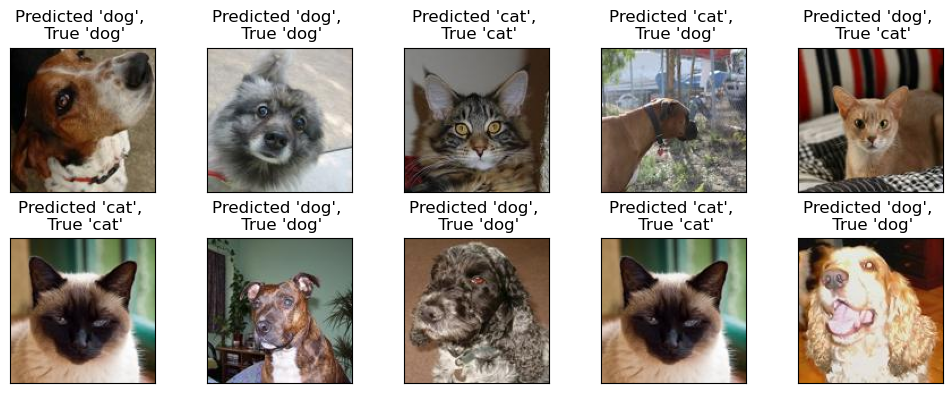

In [9]:
# Check results
def index_to_pet(index):
    if index == 0: return "cat"
    else: return "dog"

def plot_results(model, validation_data):
    model.to(torch.device("cpu"))
    f, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        index = np.random.randint(len(validation_data))
        x, y = validation_data[index]
        c = torch.sigmoid(model(x.unsqueeze(0))) >= 0.5
        x = 0.5 * (x + 1.0)
        ax = axs.ravel()[i]
        ax.imshow(to_pil_image(x))
        title = "Predicted '{}', \n True '{}'"
        title = title.format(index_to_pet(c), index_to_pet(y))
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

plot_results(fc_model, validation_data_catsndogs)

# Convoluted Neural Network Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 2 * 2, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = self.fc(x)
        return x

# Load Dogs and Cats dataset
transform = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])
images = datasets.ImageFolder(folder, transform=transform)
n_train = int(0.9 * len(images))
n_val = len(images) - n_train
training_data_catsndogs, validation_data_catsndogs = torch.utils.data.random_split(images, (n_train, n_val))
training_loader = DataLoader(training_data_catsndogs, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data_catsndogs, batch_size=64, shuffle=True)

conv_model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.001)

# Train the model
conv_model.train()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv_model.to(device)
for epoch in range(5):
    print(f'Epoch {epoch+1}')
    training_loss = 0.0
    n = len(training_loader)
    for i, data in enumerate(training_loader, 0):
        x, y = data
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        outputs = conv_model(x)
        loss = criterion(outputs.squeeze(), y.float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        #print("Training")
    training_loss /= n
    print('training_loss:',training_loss)
    conv_model.eval()
    validation_loss = 0.0
    n = len(validation_loader)
    for i, data in enumerate(validation_loader):
        x = x.to(device)
        y = y.to(device)
        # Predict output, compute loss, perform optimizer step.
        outputs = conv_model(x)
        loss = criterion(outputs.squeeze(), y.float())
        validation_loss += loss.item()
        #print("Batch ({} / {}): Loss {:.2f}".format(i, n, loss.item()), end="\r")
    validation_loss /= n
    print('validation_loss:',validation_loss)

print('Finished Training')

Epoch 1
training_loss: 0.6237890181087312
validation_loss: 0.6950355768203735
Epoch 2
training_loss: 0.5969186439400628
validation_loss: 0.5701085329055786
Epoch 3
training_loss: 0.5680153284754071
validation_loss: 0.6172665357589722
Epoch 4
training_loss: 0.5286594380935034
validation_loss: 0.49288609623908997
Epoch 5
training_loss: 0.46913533054646994
validation_loss: 0.3928578197956085
Finished Training


In [11]:
# Alter the Complexity of the Network: Increase filters, add convolution layers and adjust kernel sizes
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # New 4th convolutional layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        input_image_size = 128
        # Calculate the size after conv and pooling layers
        def size_after_conv(size, kernel_size, stride): return (size - (kernel_size - 1) - 1) // stride + 1
        def size_after_pool(size, kernel_size, stride): return size_after_conv(size, kernel_size, stride)
            
        size = size_after_conv(input_image_size, 5, 1)  # After first conv
        size = size_after_pool(size, 4, 4)              # After first pool
        size = size_after_conv(size, 4, 1)              # After second conv
        size = size_after_pool(size, 2, 2)              # After second pool
        size = size_after_conv(size, 3, 1)              # After third conv
        size = size_after_pool(size, 2, 2)              # After third pool
        size = size_after_conv(size, 3, 1)              # After fourth conv
        size = size_after_pool(size, 2, 2)              # After fourth pool
        fc_input_size = size * size * 128
        self.fc = nn.Linear(fc_input_size, 1)

    def forward(self, x):
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))  # Apply the new layers
        x = x.view(-1, self.num_flat_features(x))  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

    # Helper function- number of flat features
    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Alteration with learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model again to check results
conv_model.train()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv_model.to(device)

for epoch in range(5):
    print('Epoch',epoch)
    training_loss = 0.0
    n = len(training_loader)
    for i, data in enumerate(training_loader, 0):
        x, y = data
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        outputs = conv_model(x)
        loss = criterion(outputs.squeeze(), y.float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        
    training_loss /= n
    print('training_loss:',training_loss)

    scheduler.step() #learning rate updated- called after each epoch
    conv_model.eval()
    validation_loss = 0.0
    n = len(validation_loader)

    with torch.no_grad():
        for i, (x, y) in enumerate(validation_loader):
            x = x.to(device)
            y = y.to(device)
            outputs = conv_model(x)
            loss = criterion(outputs.squeeze(), y.float())
            validation_loss += loss.item()
    validation_loss /= n
    print('validation_loss:', validation_loss)

print('Finished Training')

Epoch 0
training_loss: 0.3910477920657113
validation_loss: 0.40631558299064635
Epoch 1
training_loss: 0.3474360253839266
validation_loss: 0.36518779397010803
Epoch 2
training_loss: 0.3194760268642789
validation_loss: 0.3769944667816162
Epoch 3
training_loss: 0.2986342945978755
validation_loss: 0.38452147245407103
Epoch 4
training_loss: 0.28243396218333927
validation_loss: 0.3498036801815033
Finished Training


# Comparison: Evaluation on test set

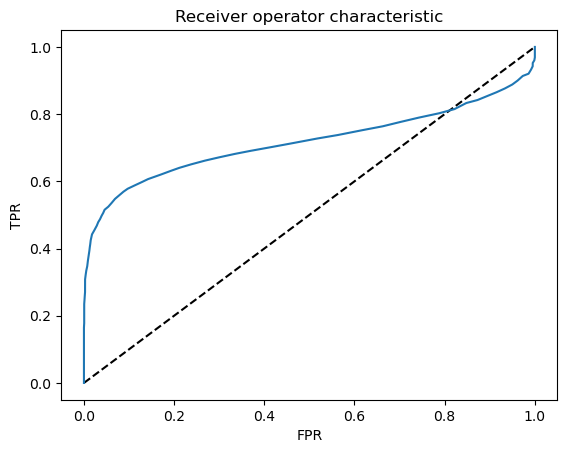

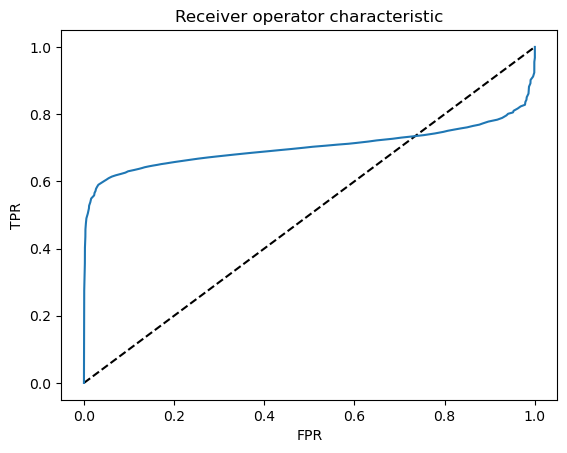

In [12]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

test_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
test_dataset = datasets.ImageFolder(folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def get_predictions_and_targets(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs).view(-1).cpu().numpy()
            predictions.extend(probabilities)
            targets.extend(labels.cpu().numpy())
    return predictions, targets

cnn_model = conv_model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ps = np.linspace(0, 1, 100)
cnn_model.eval()
fc_model.eval()
cnn_model.to(device)
fc_model.to(device)

# ROC curve
fpr_fc, tpr_fc = receiver_operating_characteristic(fc_model, test_loader, ps)

# Transform for CNN
transform_cnntest = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])
images = datasets.ImageFolder(folder, transform=transform_cnntest)
test_loader_cnn = DataLoader(images, batch_size=64, shuffle=False)
fpr_cnn, tpr_cnn = receiver_operating_characteristic(cnn_model, test_loader_cnn, ps)

# AUC ROC for both models
auc_roc_fc = auc_roc(fpr_fc, tpr_fc)
auc_roc_cnn = auc_roc(fpr_cnn, tpr_cnn)

# Plot ROC curves
plot_ROC(fpr_fc, tpr_fc)
plot_ROC(fpr_cnn, tpr_cnn)

In [13]:
#predictions
predictions_fc, targets_fc = get_predictions_and_targets(fc_model, test_loader)
predictions_cnn, targets_cnn = get_predictions_and_targets(cnn_model, test_loader_cnn)

def compute_accuracy(y_scores, y_true, threshold=0.5):
    y_pred = (np.array(y_scores) > threshold).astype(int)
    correct_predictions = np.sum(y_pred == np.array(y_true))
    accuracy = correct_predictions / len(y_true)
    return accuracy

accuracy_fc = compute_accuracy(predictions_fc, targets_fc, threshold=0.5)
accuracy_cnn = compute_accuracy(predictions_cnn, targets_cnn, threshold=0.5)
print(f"Accuracy of Fully Connected Model: {accuracy_fc:.4f}")
print(f"Accuracy of Convolutional Neural Network Model: {accuracy_cnn:.4f}")

Accuracy of Fully Connected Model: 0.6549
Accuracy of Convolutional Neural Network Model: 0.8816


Fully Connected Model Predictions:


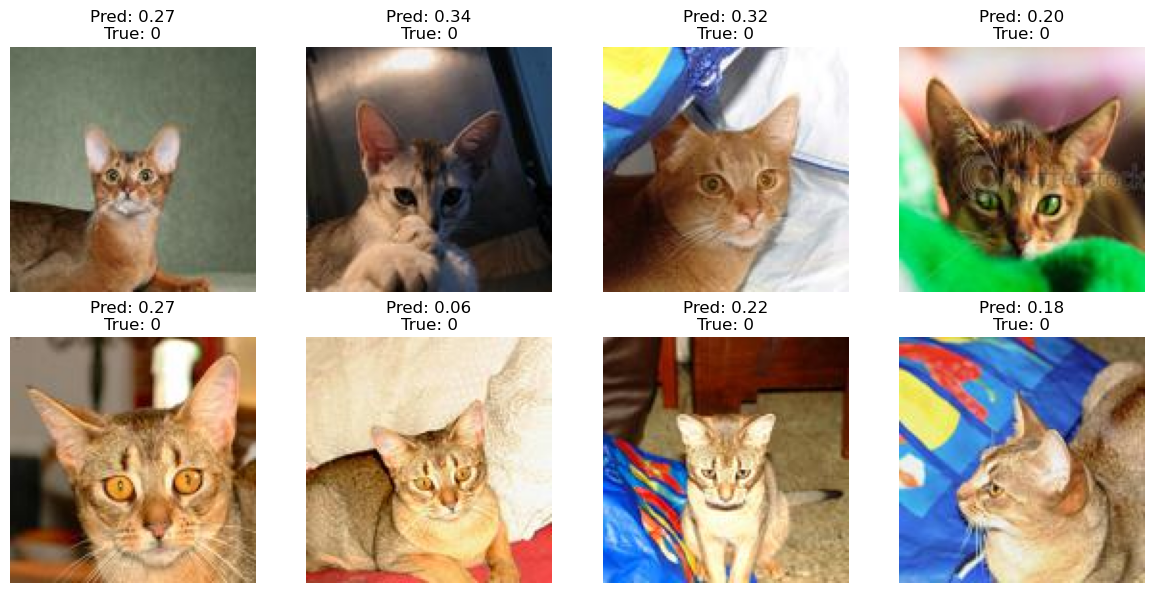

Convolutional Neural Network Model Predictions:


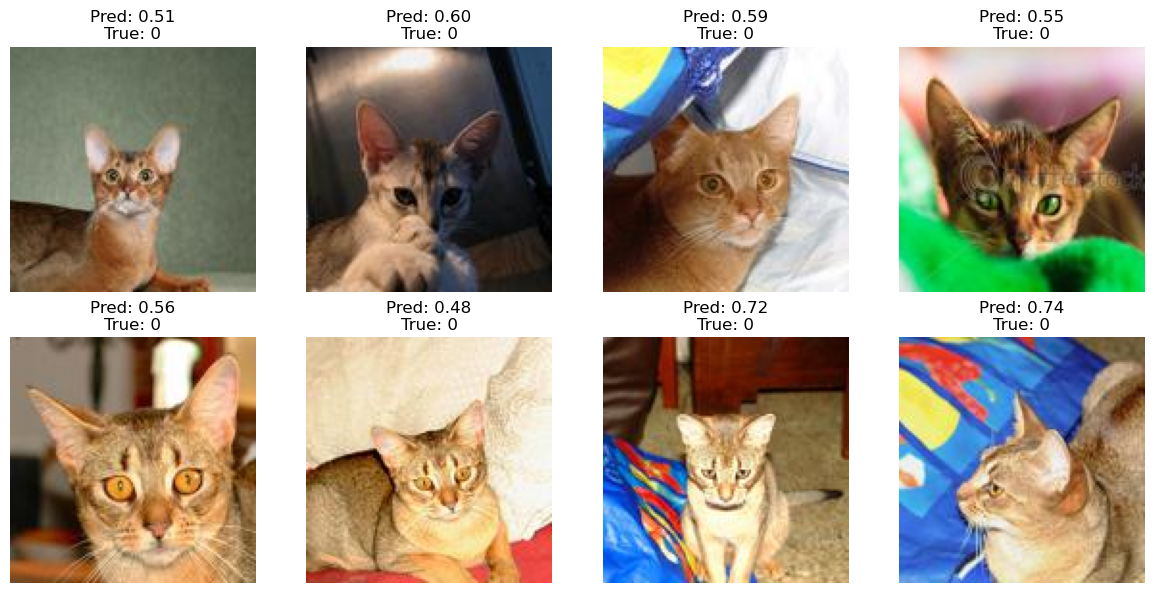

In [14]:
def plot_sample_predictions(model, data_loader, num_images=8):
    model.eval()
    device = next(model.parameters()).device
    images, predictions, true_labels = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
            images.extend(inputs.cpu())
            predictions.extend(probabilities)
            true_labels.extend(labels.cpu().numpy())
            if len(images) >= num_images: break

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(to_pil_image(images[i]), cmap="gray")
        plt.title(f"Pred: {predictions[i]:.2f}\nTrue: {true_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Fully Connected Model Predictions:")
plot_sample_predictions(fc_model, test_loader)
print("Convolutional Neural Network Model Predictions:")
plot_sample_predictions(cnn_model, test_loader)

**Results: CNN much better than MLP**